<a href="https://colab.research.google.com/github/fedhere/MLTSA_FBianco/blob/master/HW3/uberprophet_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This homework will guide you through a complete additive model analysis of a time series and familiarize you with the (fairly new) [Facebook Prophet](https://facebook.github.io/prophet/) package for time series analysis. 

Prophet simplifies the implementation of analysis like "Structural Time Series modeling" and/or "Bayesian dynamic linear model": similarly to the ARMA family of models, these models attempt to recreate (and predict) a time series by linearly combining variouos components: trends, seasonalities, but also regression on exogenous variables. In this case, we will see if Uber rides area affected by weather, in additional to trends and seasonality. 

Under the hood, the model will implement an optimization to find the best fit parameters for each component (mostly the relative amplitude of each component) in a Bayesian framework, either as a direct optimization which is possible since the model is linear, or by MCMC (https://github.com/facebook/prophet/issues/669)




In [52]:
import pandas as pd
import pylab as pl
from google.colab import drive
import pylab as pl
import warnings
warnings.simplefilter("ignore")
%pylab inline

Populating the interactive namespace from numpy and matplotlib


 
# DATA ANALYSIS 0: we will use the package Prohpet, created by facebook for time series analysis. 
Install the package and import it. The model that you will use is Prophet. Also import the diagnostics package from fbprophet


In [2]:
!pip install fbprophet
!pip install wwo_hist

  Created wheel for wwo-hist: filename=wwo_hist-0.0.4-cp36-none-any.whl size=4216 sha256=12b68946eadcd2bd4370e1647f54b7e0b5e137b3a5ba30c4f0bf90994dd3ad71
  Stored in directory: /root/.cache/pip/wheels/c5/0e/16/329d9233f3b0b7e5fe81b09c5519a193727999c6ae77577ca9
Successfully built wwo-hist


In [0]:
import fbprophet
from wwo_hist import retrieve_hist_data

In [0]:
from fbprophet import Prophet
from fbprophet import diagnostics

# 1. DATA ACQUISITION 1: write a for loop that extracts files from the repository https://github.com/fivethirtyeight/uber-tlc-foil-response. 

There are a number of csv files in the repository, and a zip file. Read in within the loop the 6 csv files representing uber pickup deives from April to September 2014. This can be done with a for loop iterating in a container that contains the apporopriate string identified in the file names (e.g. 'apr' for April) and composes the string using an immutable root, the month name, and the immutable ending of the file. Remember to read in the raw files. Remember that ```pd_read_csv ()``` accepts URLs, so you do not have to download the data.

At the end you need the data to be appended into a single datafraom (note: appended, i.e. concatenated, not merged.) You can achieve this in many ways, an easy (and a bit lazy one) is to append each file read in as a dataframe to a list and use ```pd.concat(list)``` to concatenate them into a single dataframe.

In [5]:
a = []
for mon in ['apr', 'may', 'jun', 'jul', 'aug', 'sep']:
    f = "https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-" + mon + "14.csv"
    print(f)
    a.append(pd.read_csv(f))

https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-apr14.csv
https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-may14.csv
https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-jun14.csv
https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-jul14.csv
https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-aug14.csv
https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-sep14.csv


In [0]:
uberrides = pd.concat(a)

# DATA PREPARATION 1: convert the dates to datetime and generate a time series of rides/day. 
Note that at this stage this is not the kind of time series you need. You need number of rides per unit time (e.g. per day) and we have timsetamp of each ride. 
To obtain that you can use the ```groupby()``` method of your dataframe. Before that, convert the date time column to ```pd.datetime``` type (this may take a while), then you can use groupby with the "date" attribute, which means grouping by day, and use the method count of groupby to count the number of rides in each group. 

Finally, rename the dataframe so that the number of rides is column ```y``` and the dates are column ```ds``` - this is required by the prophet package that you will use for the enalysis.

** plot the resulting dataframe

In [0]:
#converting to datetime objects
uberrides["time"] = pd.to_datetime(uberrides["Date/Time"])

In [22]:
uberrides.head()

,Date/Time,Lat,Lon,Base,time
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512,2014-04-01 00:11:00
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512,2014-04-01 00:17:00
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512,2014-04-01 00:21:00
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512,2014-04-01 00:28:00
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512,2014-04-01 00:33:00


Table 1: the beginning and end of the input datset. The data includes a time stamp, spatial coordinates, and a code for the car. The date appears twice, first as a string, then as a timestamp after conversion.


In [9]:
#checking one element
uberrides.iloc[0]["time"].date()

datetime.date(2014, 4, 1)

In [15]:
uberbyday = uberrides.groupby(uberrides["time"].dt.date).count()
uberbyday

,Date/Time,Lat,Lon,Base,time
time,,,,,
2014-04-01,14546,14546,14546,14546,14546
2014-04-02,17474,17474,17474,17474,17474
2014-04-03,20701,20701,20701,20701,20701
2014-04-04,26714,26714,26714,26714,26714
2014-04-05,19521,19521,19521,19521,19521
...,...,...,...,...,...
2014-09-26,37504,37504,37504,37504,37504
2014-09-27,39468,39468,39468,39468,39468
2014-09-28,29656,29656,29656,29656,29656


Note: this is not a deliverable: I am leaving it here for your inspectoin

In [0]:
#renaming the variables according to the fbprophet package requirement
uberbyday = uberrides.groupby(uberrides["time"].dt.date).count()[["time"]]
uberbyday.rename({"time":"y"}, axis=1, inplace=True)
uberbyday["ds"] = uberbyday.index.values


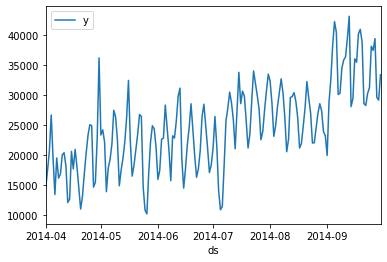

In [17]:
uberbyday.plot(x="ds", y="y");

Fig 1: Number of Uber rides per day since April 4th through April 30th 2014 from the "fivethirtyeight" dataset as accessed on Feb 25th 2020 at https://github.com/fivethirtyeight/uber-tlc-foil-response. By visual inspection the data shows both an upward trend, seasonalities (a weekly and possibly a seasonal ~few months cycle, and unusual drop and spikes, that are potential anomalies. A break point is also visible in September 2014.

# DATA PREPARATION 2: stanardize the data
Subtract the mean and divide by the standard eviation the ```y``` column. Although this is not strictly necessary to work with the Prophet package, it is in general recommanded not to use large numbers in your analysis. furtehrmore, this will convert the target variable to a floating point, which is a better type for regression

In [0]:
uberbyday['y'] = (uberbyday.y - uberbyday.y.mean()) / uberbyday.y.std()

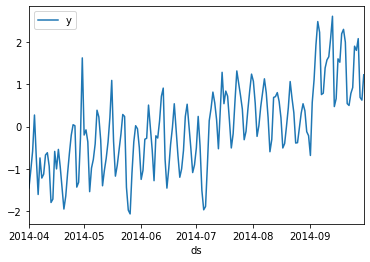

In [19]:
uberbyday.plot(x="ds", y="y");

Fig 2: as Fig 1 but after standardizing the data

# DATA ANALSYS 1: fit the uber rides data with the prophet model. 
The model will look for seasonality and trends automatically. It is a bit of a black box and I dont have a lot of experience with it, but it is really "cutting edge" in this field.
As with any object oriented package, you first need to invoke ```Phrophet()``` to create a model, call it ```simplem```, then fit it to the uber data. Forecast 1 month past the last available datapoint and print the last 5 entries of the resulting dataframe. Plot the forecast, including the uncertainty regions of the forecast and the comonents of the forcast which should be the trend and the weekly seanality. The model should naturally produce these components. If it does not look into the model and the settings by displaying the model methods (e.g. type ```siplemodel.``` and press the tab key.) Remember that ou MUST describe what you see in these plots!


In [20]:
simplem = Prophet()
simplem.fit(uberbyday)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [21]:
future = simplem.make_future_dataframe(periods=30)
forecast = simplem.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
208,2014-10-26,0.671657,0.011817,1.348546
209,2014-10-27,0.950767,0.275073,1.552156
210,2014-10-28,1.528120,0.869266,2.184470
211,2014-10-29,1.885666,1.253057,2.559315
212,2014-10-30,2.204848,1.547038,2.876780


Table 2: the forcasted data for the Facebook Prophet model run "naively" with default parameters predicting 30 days after the last date.

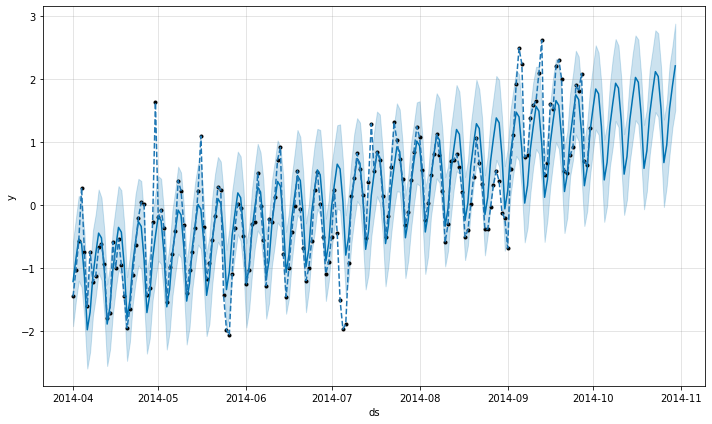

In [0]:
fig1 = simplem.plot(forecast)
pl.plot(uberbyday.y, '--');

Prediction from the Facebook Prophet model: the solid blue line is the expected value for the prediction (mean) and the uncertainty is represented by a light blue band. The black datapoints are the input data. the model predicts well the seasonal effects, but fails to predict anomalies or the break in the data. The model prediction extends 30 days after the end of the dataset (30 periods)

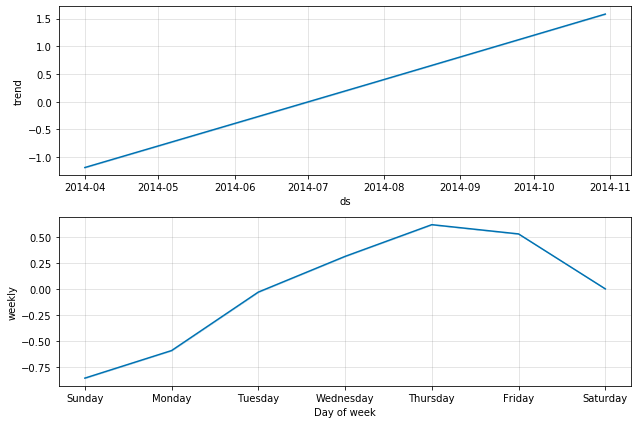

In [0]:
fig2 = simplem.plot_components(forecast)


Fig 4: Components of the "naive" prophet facebook model: the top plot shows the increasing trend in rides over the time period considered: it is a straight line (by design of the model) with an growth rate (growth factor) just smaller than 0.5 per month (a factor if ~3 over the 6 months of available data.) The bottom plot shows the seasonal weekly cycle: the model is asymmetric, not only because the baseli
ne is 7 days, but because of the different nature of week vs weekend days. Note that after Sunday the lowest number of rides  is Monday, which is curious and woudl be worth more analysis.

# DATA ANALYSIS 2: Crossvaliate your model and create a function to evaluate the goodness of fit of your model. 
Use the chisquare per degree of freedom (also calle reduced chi square, note that this quantity has a theoretical expectation value of 1 for a perfect model): the chi square divided by the number of observations.Use 30 days for crossvalidation. The diagnostics function will return all that you need to calculate your reduce chi2. Howeve, we o not have the uncertainties to put them in the formula (we could create them from count statistics, but I wont ask you to) so set the uncertainties to 1. With unerestimated uncertainties this quantity is likely to be less than 1.

You can read about cross valiation for regression here https://robjhyndman.com/hyndsight/tscv/ (but do not set the period=1 or the process would take too long)

In [70]:
def rchi2(y, ytrue):
    '''"pseudo" reduced chi square: assumes that the 
    degrees of freedom are == to the number of points 
    (i.e. that the number of parameters
    is neligeable compared to the number of datapoints) 
    and that the return uncertainty is =1 for all datapoints (homeoschedastic).
    Effectively this is a root-mean-square error with a normalization that 
    should cause the result of good models to be ~1 
    inputs:
    - y: prediction : n-size array or list
    - ytrue: endogenous variable : n-size array or list
    '''
    return ((y -  ytrue)**2).sum() / len(y)



INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-07-02 00:00:00 and 2014-08-31 00:00:00


In [0]:
cvresult_simplem = diagnostics.cross_validation(simplem, horizon="30 days")

In [0]:
diagnostics.cross_validation?

Note: the .cross_validation() method "Computes forecasts from historical cutoff points. Beginning from
(end - horizon), works backwards making cutoffs with a spacing of period until initial is reached." In practice: it predicts data at N point within the time series where N is given by how meny chunks of size "period" you can fit in the time series. "Horizon" is how far forward of the last datapoint you want to predict. 

In [72]:
print("The 'pseuido'reduced chi square " + 
      "of the naive model is {:0.2}".format(rchi2(cvresult_simplem.y, 
                              cvresult_simplem.yhat)))

The reduced chi square (chi square per degree of freedom) of the naive model is 0.46


# DATA ACQUISITION 2: dooownload exogenous variable data. 
One may guess that weather would affect the number of rides: a trivial example is that if it rains people are less likely to walk. It might not be that trivial tho, maybe if it  rains people are altogether less likely to go out.

Acquire weather data for NYC for the relevant time period from the www.worldweatheronline.com website through the wwo_hist API. You will have to 1) request a key https://www.worldweatheronline.com/developer/api/, https://www.worldweatheronline.com/developer/signup.aspx ( it is free for <500 requests).
an install and import the ```wwo_hist``` package

Save your key in a separate file and read it in. For example, you can create a file ```my_apis.csv``` in the same folder where you are working and the content of the file can be ```wwo,XXXXXXXXXXXXXXXXX```

This should download a ```New+york,ny.csv``` file which you can then read in. Convert the atetime entry to pd.datetime as you did before and merge the uber reides and the weather dataframe on the date feature. YOud rataframe should now have columns ```y, ds, tempC, precipMM```. You should stanardize the tempC and precipMM features as you did for the number of rides.

Plot each feature.

In [32]:

drive.mount("/content/gdrive")


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [33]:
cd gdrive/My\ Drive

/content/gdrive/My Drive


In [0]:
api_key = pd.read_csv("my_apis.csv", header=None, index_col=0).loc["wwo"].values[0]


In [37]:
frequency = 24
start_date = '04-01-2014'
end_date = '09-30-2014'
api_key = pd.read_csv("my_apis.csv", header=None, index_col=0).loc["wwo"].values[0]
location_list = ['New+york,ny']
hist_weather_data = retrieve_hist_data(api_key,
                                location_list,
                                start_date,
                                end_date,
                                frequency,
                                location_label = False,
                                export_csv = True)



Retrieving weather data for New+york,ny


Currently retrieving data for New+york,ny: from 2014-04-01 to 2014-04-30
Time elapsed (hh:mm:ss.ms) 0:00:00.661919
Currently retrieving data for New+york,ny: from 2014-05-01 to 2014-05-31
Time elapsed (hh:mm:ss.ms) 0:00:01.338471
Currently retrieving data for New+york,ny: from 2014-06-01 to 2014-06-30
Time elapsed (hh:mm:ss.ms) 0:00:01.929717
Currently retrieving data for New+york,ny: from 2014-07-01 to 2014-07-31
Time elapsed (hh:mm:ss.ms) 0:00:02.565760
Currently retrieving data for New+york,ny: from 2014-08-01 to 2014-08-31
Time elapsed (hh:mm:ss.ms) 0:00:03.205664
Currently retrieving data for New+york,ny: from 2014-09-01 to 2014-09-30
Time elapsed (hh:mm:ss.ms) 0:00:03.851124
Currently retrieving data for New+york,ny: from 2014-09-01 to 2014-09-30
Time elapsed (hh:mm:ss.ms) 0:00:04.475944


export New+york,ny completed!




In [38]:
pd.read_csv("New+york,ny.csv").columns


Index(['date_time', 'maxtempC', 'mintempC', 'totalSnow_cm', 'sunHour',
       'uvIndex', 'uvIndex.1', 'moon_illumination', 'moonrise', 'moonset',
       'sunrise', 'sunset', 'DewPointC', 'FeelsLikeC', 'HeatIndexC',
       'WindChillC', 'WindGustKmph', 'cloudcover', 'humidity', 'precipMM',
       'pressure', 'tempC', 'visibility', 'winddirDegree', 'windspeedKmph'],
      dtype='object')

In [0]:
weather = pd.read_csv("New+york,ny.csv")[["date_time", "tempC", "precipMM"]]


In [0]:
weather.index = pd.to_datetime(weather.date_time)

In [41]:
weather.head()

,date_time,tempC,precipMM
date_time,,,
2014-04-01,2014-04-01,12,0.0
2014-04-02,2014-04-02,12,0.2
2014-04-03,2014-04-03,13,0.0
2014-04-04,2014-04-04,6,4.5
2014-04-05,2014-04-05,10,0.1


Table 3: the weather data collected from WorldWeatherOnline retrieved with the Python API https://pypi.org/project/wwo-hist/ on Feb 25th 2020: data include a time stamp, precipitation in millimeters, and temperature in Celsius, and are for NYC 

In [0]:
weather.drop("date_time", axis=1, inplace=True)

In [0]:
uberweather = uberbyday.merge(weather, left_index=True, right_index=True)

In [44]:
uberweather

,y,ds,tempC,precipMM
2014-04-01,-1.449528,2014-04-01,12,0.0
2014-04-02,-1.034719,2014-04-02,12,0.2
2014-04-03,-0.577551,2014-04-03,13,0.0
2014-04-04,0.274309,2014-04-04,6,4.5
2014-04-05,-0.744721,2014-04-05,10,0.1
...,...,...,...,...
2014-09-28,0.691101,2014-09-28,26,0.0
2014-09-29,0.626642,2014-09-29,24,0.1
2014-09-29,0.626642,2014-09-29,24,0.1
2014-09-30,1.225904,2014-09-30,21,0.8


Table 4: merged uber rides (standardized, Table 2) and weather data (Table 3), merged by day.

In [0]:
uberweather.y = (uberweather.y - uberweather.y.mean()) / uberweather.y.std()
uberweather.tempC = (uberweather.tempC - uberweather.tempC.mean()) / uberweather.tempC.std()
uberweather.precipMM = (uberweather.precipMM - uberweather.precipMM.mean()) / \
        uberweather.precipMM.std()

In [46]:
#leave
uberweather

,y,ds,tempC,precipMM
2014-04-01,-1.521465,2014-04-01,-1.959822,-0.484962
2014-04-02,-1.136392,2014-04-02,-1.959822,-0.430609
2014-04-03,-0.711997,2014-04-03,-1.766830,-0.484962
2014-04-04,0.078797,2014-04-04,-3.117776,0.737969
2014-04-05,-0.867183,2014-04-05,-2.345807,-0.457786
...,...,...,...,...
2014-09-28,0.465711,2014-09-28,0.742069,-0.484962
2014-09-29,0.405872,2014-09-29,0.356084,-0.457786
2014-09-29,0.405872,2014-09-29,0.356084,-0.457786
2014-09-30,0.962176,2014-09-30,-0.222892,-0.267552


Table 5: same as Table 4 but standardized along each features, including weather features.

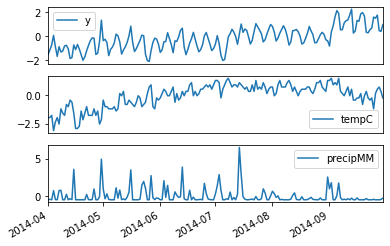

In [53]:
fig, ax = pl.subplots(3)
uberweather.plot(y="y", ax=ax[0])
ax[0].set_xticks([])
uberweather.plot(y="tempC", ax=ax[1])
ax[1].set_xticks([])
uberweather.plot(y="precipMM", ax=ax[2]);

Figure 5: The input data: the top plot is the same as Figure 2, the bottom plots are the standardized temperature and precipitations, respectively.

   # DATA ANALAYSIS 2: create a new Prophet model and add to it tempC and precipMM as regressors
Use the model method ```model.add_regressor()```. Call the model ```regrm```. Fit the model and cross valiate it. Plot the 2 models and calculate the reduced chi2 for each model and compare. Note that here you should not forecast, since you do not have the future values of the weather. If you wanted to go through the trouble to get future weather and forecast that is definitely a good extra credit!

In [54]:
regrm = Prophet()
regrm.add_regressor("tempC")
regrm.add_regressor("precipMM")

In [55]:
regrm.fit(uberweather)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


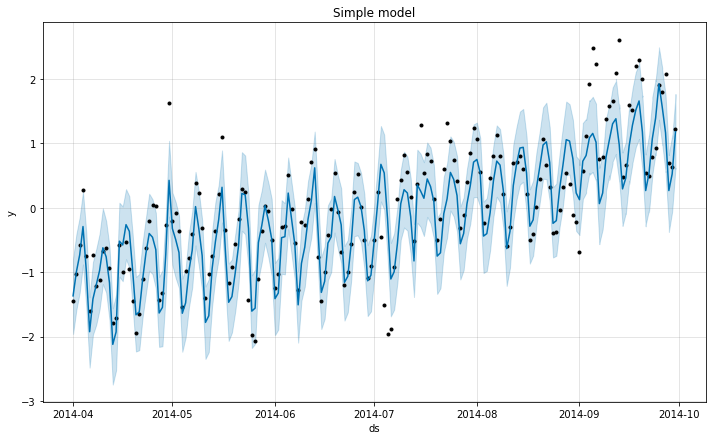

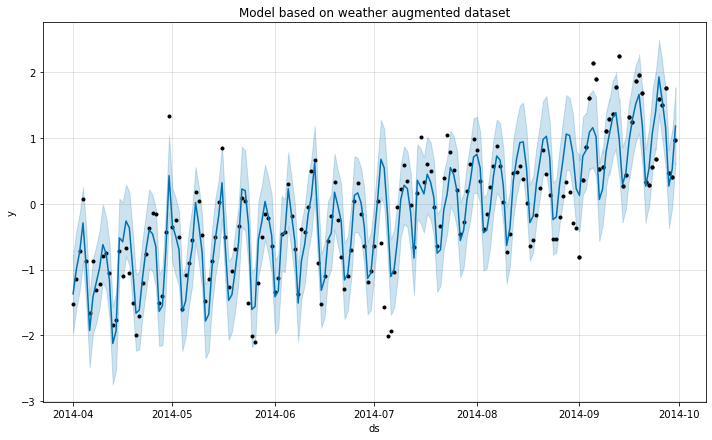

In [59]:
#delete
nowcast = regrm.predict(uberweather)

simplem.plot(nowcast)
pl.title("Simple model")
regrm.plot(nowcast)
pl.title("Model based on weather augmented dataset");
#pl.plot(uberbyday.y, '--')

Figure 6: the Prophet model in-sample predictions (not extrapoliation to later dates) based on the simple datadriven "naive" model and on a model with added exogenous variables related to weather: temperature and precipitation.The more complex models captures some if the anomalies better, for example the high datapoint in mid May and several of the outliers in Septembers are now within the errorbars.

In [60]:
cvresult_regr = diagnostics.cross_validation(regrm, horizon="30 days")

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-07-02 00:00:00 and 2014-08-31 00:00:00


In [63]:
print("The reduced chi square (chi square per degree of freedom) " + 
      "of the model based on weather augmented data is {:0.2}".format(
          rchi2(cvresult_regr.y, cvresult_regr.yhat)))

The reduced chi square (chi square per degree of freedom) of the model based on weather augmented data is 0.41


Note: while the model has a smaller chi square, this chi square does not actually include the uncertainty in the data. The uncertainty could be included assuming shot noise as the square root of the number of rides. Regardless, the decrease in chi square is encouraging, but the formula was written assuming the same number of degrees of freedom for the two models, while having increased the parameters in the data and the dimensionality of the dataset this is not true. So in conclusion, while a smaller "reduced chi sq" based on our definition of it is encouraging because it indicates smaller overall (mean squared) errors, it is not conclusive to indicate wheather a model is better than the other and does not provide any diagnostic about overfitting.

# DATA ANALSYIS 3 add holiday
Holiday of course affect traffic and ridership. Prophoet has very convenient functionality to put in holidays! This a huge simplification of the workflow in timeseries analysis! add holidays for ths us with the model ```model.add_country_holidays()``` which takes argument ```country_name="US"``` in the case of the US. Once again, fit, predict, plot, crossvalidate, calculate and compare the reduced chi2


In [64]:
regholm = Prophet()
regholm.add_regressor("tempC")
regholm.add_regressor("precipMM")
regholm.add_country_holidays(country_name="US")

In [65]:
regholm.fit(uberweather)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(0.5, 1.0, 'Weather data and holiday added')

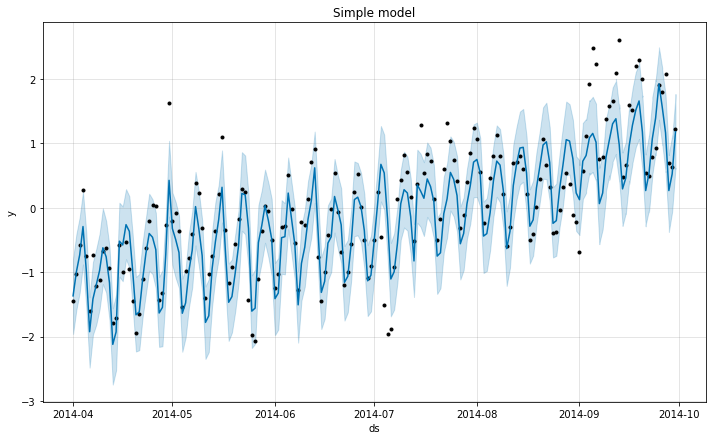

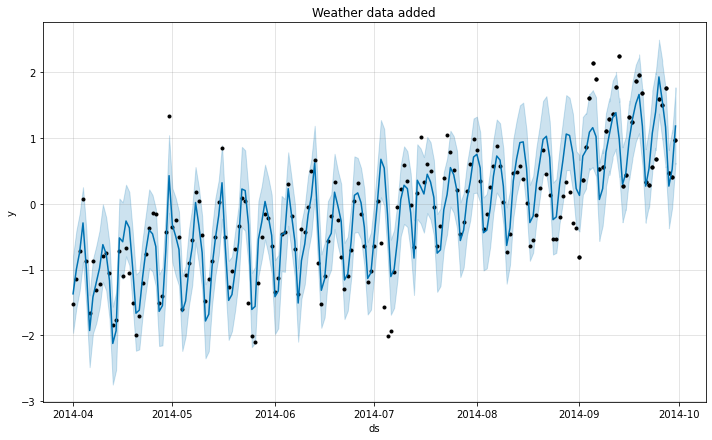

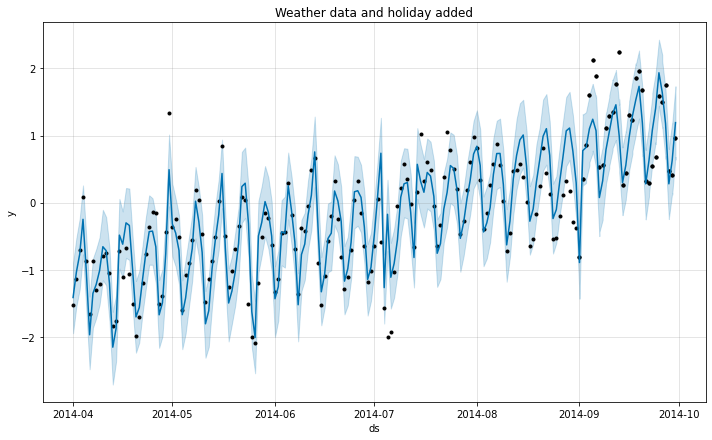

In [67]:
nowcast2 = regholm.predict(uberweather)

fig1 = simplem.plot(nowcast)
pl.title("Simple model")

regrm.plot(nowcast);
pl.title("Weather data added")

regholm.plot(nowcast2);
pl.title("Weather data and holiday added")


Figure 7:As figure 6: the plot shows the simple model based only on the uber rides data (top), the model based on augmentation with weather data (middle) and a third plot with data augmented by weather and holidays.
The last model captures anomalies that are consistent with, for example, the 4th of July and Labour day (early September) which are low points in the uber rides time series.

In [68]:
cvresult_regrhol = diagnostics.cross_validation(regholm, horizon="30 days")

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-07-02 00:00:00 and 2014-08-31 00:00:00


In [69]:
print("The 'pseuido'reduced chi square " + 
      "of the simple data-driven model is {:0.2}".format(
          rchi2(cvresult_simplem.y, cvresult_simplem.yhat)))
print("The 'pseuido'reduced chi square " + 
      "of the model based on weather augmented data is {:0.2}".format(
          rchi2(cvresult_regr.y, cvresult_regr.yhat)))
print("The 'pseuido'reduced chi square " + 
      "of the model based on weather augmented and holiday data is {:0.2}".format(
    rchi2(cvresult_regrhol.y, cvresult_regrhol.yhat)))

The reduced chi square (chi square per degree of freedom) of the simple data-driven model is 0.46
The reduced chi square (chi square per degree of freedom) of the model based on weather augmented data is 0.41
The reduced chi square (chi square per degree of freedom) of the model based on weather augmented and holiday data is 0.38


Note: as above, the decrease in the chi squared as defined by us reflects an improvement in the mean square error, but without accounting for the extra parameters it is not possible to tell if the addition of parameters is justified by the improvement in the fit. Nonetheless, we have seen that the inclusion of holidays in the model allow to fit specific dates better. 

# DATA ANALYSIS 4: this whole thing can be done with MCMC optimization in a fully bayesian framework. 
Add the argument mcmc_samples=5000 to Propher in your next model and see how it goes. Make the usual plots and calculate the reduced chi2 one last time

In [0]:
regmcmc = Prophet(mcmc_samples=5000)

In [74]:
regmcmc.add_regressor("tempC")
regmcmc.add_regressor("precipMM")
regmcmc.add_country_holidays(country_name="US")

In [75]:
regmcmc.fit(uberweather)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [0]:
cvresult_regmcmc = diagnostics.cross_validation(regmcmc, horizon="30 days")

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-07-02 00:00:00 and 2014-08-31 00:00:00


In [0]:
print("The 'pseuido'reduced chi square " + 
      "of the model based on weather augmented and holiday data is {:0.2}".format(
    rchi2(cvresult_regrhol.y, cvresult_regrhol.yhat)))

print("The 'pseuido'reduced chi square " + 
      "of the model based on weather augmented and holiday data " +
      " and fit in am MCMC framework is {:0.2}".format(
rchi2(cvresult_regmcmc.y, cvresult_regmcmc.yhat), \


There are two packages with similar functionalities. As extra credit, repeat some of the steps of this analysis with either: Tensorflow timeseries modeling https://blog.tensorflow.org/2019/03/structural-time-series-modeling-in.html or https://github.com/wwrechard/pydlm